# 6. Линейная регрессия. Практика

✍ Настало время попрактиковаться применять модель линейной регрессии и её модификации в задачах регрессии.

В этот раз мы коснёмся мира медицинского страхования. Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

Работать будем с популярным датасетом Medical Cost Personal Datasets.

In [11]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

Прочитаем данные:

In [12]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

- age — возраст страхователя;
- sex — пол;
- bmi — индекс массы тела (кг/м2), в идеале — от 18.5 до 24.9;
- children — количество детей, охваченных медицинской страховкой;
- smoker — является ли человек курящим;
- region — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);
- charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.
Размер таблицы:

In [13]:
print(data.shape)
# (1338, 7)

(1338, 7)


Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:



In [14]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

Посмотрим на типы данных:

In [15]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

- age, bmi, children — числовые признаки;
- sex, smoker — бинарные категориальные переменные (две категории);
- region — множественные категориальные переменные (несколько категорий);
- charges — числовой целевой признак.

Прежде чем приступать к этапу подготовки данных для модели, вы можете произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

- гистограммы/коробчатые диаграммы числовых признаков;
- столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;
- диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).







In [16]:
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

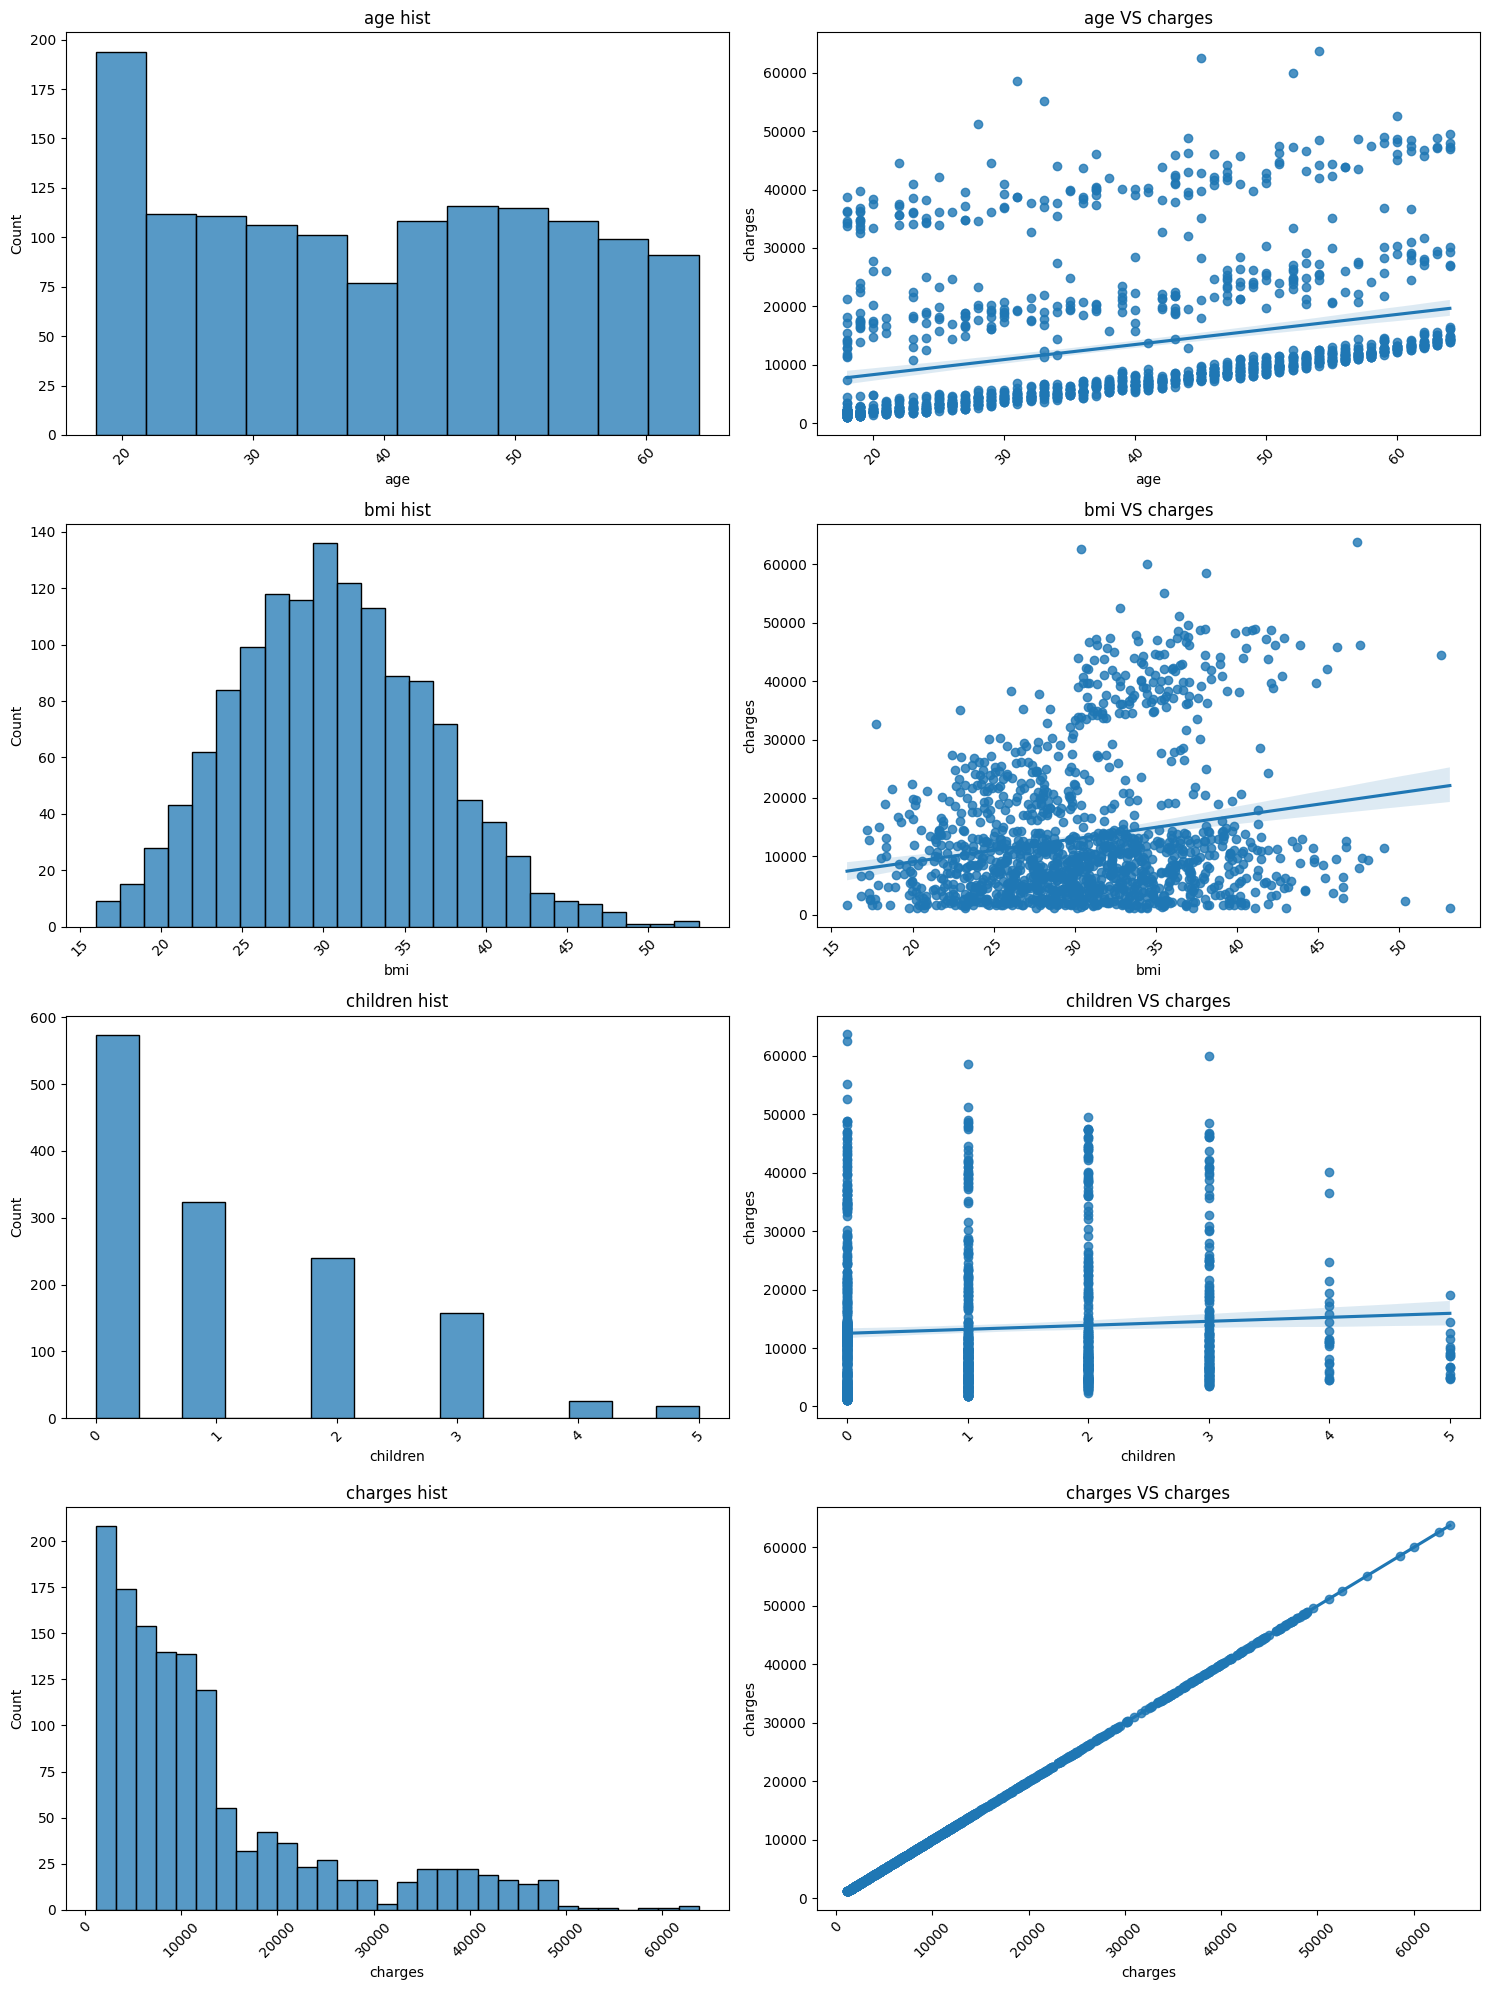

In [17]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между факторами и целевым признаком (price)

<Axes: >

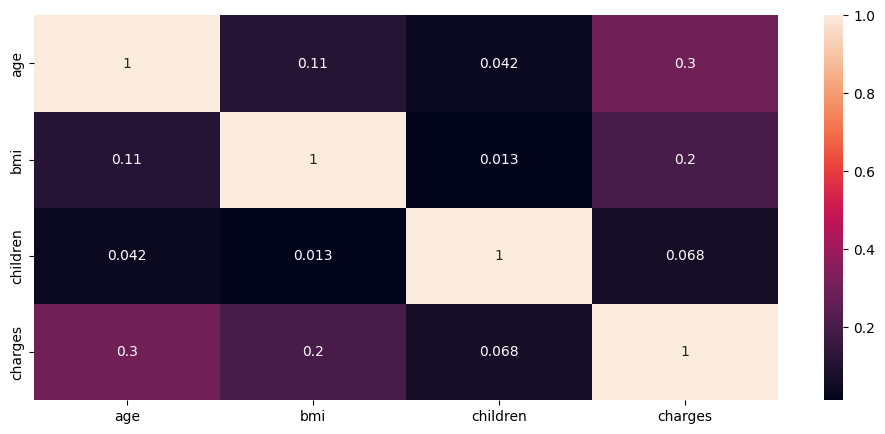

In [18]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
fig = plt.figure(figsize=(12, 5))
sns.heatmap(numeric_data.corr(), annot=True)

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
sex — аналогично (0 — female, 1 — male);
region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [19]:
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})
data['sex'] = data['sex'].map({'female': 0, 'male': 1})
data = pd.get_dummies(data, dtype=int)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Итак, мы получили перекодированную таблицу, в которой все признаки являются числовыми.

Выделим факторы и целевой признак в отдельные таблицы:

In [21]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges'] 

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


In [22]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

### Задание 6.2
1 point possible (graded)
Обучите модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных. Все параметры оставьте по умолчанию.

Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [24]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

display(round(lr.intercept_, 2))

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


np.float64(-12390.8)

### Задание 6.3
6 points possible (graded)
С помощью модели, полученной в предыдущем задании, сделайте предсказание на тренировочной и тестовой выборке. Рассчитайте следующие три метрики: R2, MAE, MAPE. Не забудьте привести значение MAPE к процентам.

Значение R2 округлите до трёх знаков после точки-разделителя, а значения MAE и MAPE — до целого числа.

Чему равны значения метрик на тренировочной и тестовой выборках?


In [25]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


### Задание 6.4
1 point possible (graded)

Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием:  y−y^  (без модуля).

Выберите верные ответы:

B Разброс ошибок на тренировочной выборке больше, чем на тестовой.
C Медианная ошибка на тренировочной и тестовой выборках отрицательная (меньше 0).

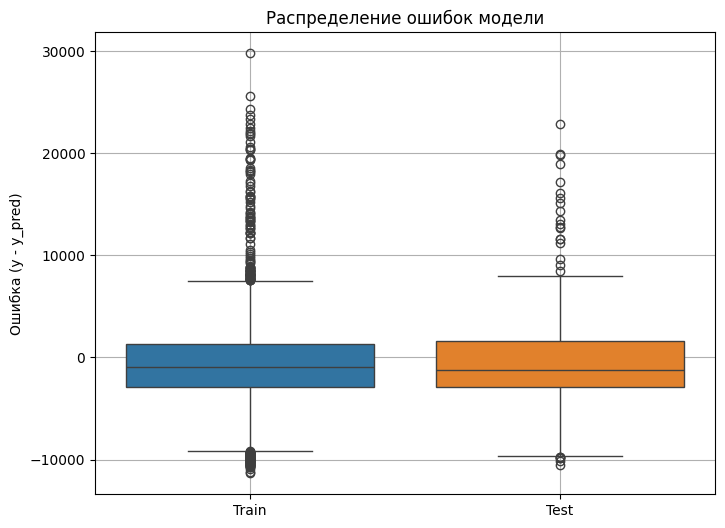


Статистика ошибок:

Тренировочная выборка:
count    1.070000e+03
mean     4.861972e-12
std      6.108400e+03
min     -1.134178e+04
25%     -2.892382e+03
50%     -9.742559e+02
75%      1.276711e+03
max      2.975138e+04
Name: charges, dtype: float64

Тестовая выборка:
count      268.000000
mean      -219.240670
std       5802.973419
min     -10512.582562
25%      -2941.141589
50%      -1242.934185
75%       1560.797841
max      22850.136498
Name: charges, dtype: float64


In [26]:
# Вычисляем ошибки для тренировочной и тестовой выборок
train_errors = y_train - lr.predict(X_train)
test_errors = y_test - lr.predict(X_test)

# Создаем DataFrame с ошибками
errors_df = pd.DataFrame({
    'Train': train_errors,
    'Test': test_errors
})

# Строим boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=errors_df)
plt.title('Распределение ошибок модели')
plt.ylabel('Ошибка (y - y_pred)')
plt.grid(True)
plt.show()

# Выводим статистику ошибок
print("\nСтатистика ошибок:")
print("\nТренировочная выборка:")
print(train_errors.describe())
print("\nТестовая выборка:")
print(test_errors.describe())

### Задание 6.5
1 point possible (graded)
Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Расчёт параметров нормализации (fit) произведите на тренировочной выборке.

Примечание. Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.

На нормализованных данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом PolynomialFeatures из библиотеки sklearn. Значение параметра include_bias выставите на False.

In [27]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))


Train shape: (1070, 54)
Test shape: (268, 54)


In [28]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)
y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2912.100
Train MAPE: 29.404


Test R^2: 0.866
Test MAE: 2755.768
Train MAPE: 30.333


### Задание 6.7
1/1 point (graded)

Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.

Какой вывод можно сделать?

Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация.

In [29]:
# Получаем имена признаков
feature_names = poly.get_feature_names_out()

# Создаем DataFrame с коэффициентами и их признаками
coefficients = pd.DataFrame(
    {'Признак': feature_names,
     'Коэффициент': lr_poly.coef_},
).round(3)

# Выводим коэффициенты
print("Коэффициенты модели:")
print(coefficients)

# Выводим свободный член
print("\nСвободный член (intercept):", round(lr_poly.intercept_, 3))

Коэффициенты модели:
   Признак   Коэффициент
0       x0 -3.062270e+16
1       x1  1.862357e+17
2       x2  5.088923e+14
3       x3  4.780135e+15
4       x4  1.282110e+16
5       x5 -1.419172e+16
6       x6 -6.616249e+15
7       x7 -6.957522e+15
8       x8 -4.209067e+15
9     x0^2  8.420000e+03
10   x0 x1  8.260000e+02
11   x0 x2  9.400000e+02
12   x0 x3 -1.674000e+03
13   x0 x4  1.200000e+02
14   x0 x5  3.062270e+16
15   x0 x6  3.062270e+16
16   x0 x7  3.062270e+16
17   x0 x8  3.062270e+16
18    x1^2 -1.530146e+17
19   x1 x2  7.137500e+02
20   x1 x3 -1.222875e+03
21   x1 x4  2.171250e+02
22   x1 x5 -3.322103e+16
23   x1 x6 -3.322103e+16
24   x1 x7 -3.322103e+16
25   x1 x8 -3.322103e+16
26    x2^2 -9.680375e+03
27   x2 x3  1.604438e+03
28   x2 x4  5.482095e+04
29   x2 x5 -5.088923e+14
30   x2 x6 -5.088923e+14
31   x2 x7 -5.088923e+14
32   x2 x8 -5.088923e+14
33    x3^2 -2.048000e+03
34   x3 x4 -2.234000e+03
35   x3 x5 -4.780135e+15
36   x3 x6 -4.780135e+15
37   x3 x7 -4.780135e+15
38  

### Задание 6.8
3 points possible (graded)
Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

Чему равны метрики R2, MAE и MAPE на тестовой выборке?

Значение R2 округлите до трёх знаков после запятой, а значения MAE и MAPE до целого числа.



In [30]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель предсказывать логарифм целевого признака
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_pred = lasso_lr_poly.predict(X_test_scaled_poly)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070
